In [35]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [36]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [37]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle=True, 
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5114 files belonging to 11 classes.


In [38]:
class_names = dataset.class_names
print(class_names)

['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato___Bacterial_spot', 'Tomato___Late_blight', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___healthy']


In [39]:
len(dataset)

160

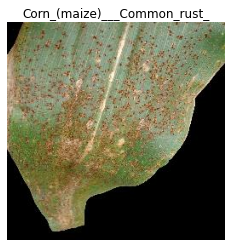

In [40]:
for image_batches, label_batches in dataset.take(1):
    plt.imshow(image_batches[0].numpy().astype("uint8"))
    plt.title(class_names[label_batches[0]])
    plt.axis("off")

In [44]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    
    ds_size=len(ds)
    
    train_size = int(ds_size*train_split)
    val_size = int(ds_size*val_split)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds 

In [45]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [72]:
len(train_ds)

128

In [46]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [47]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [48]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [49]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 11

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
    
])

model.build(input_shape = input_shape)

In [65]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [51]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [52]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
)

Epoch 1/50


128/128 [==============================] - 546s 4s/step - loss: 2.1630 - accuracy: 0.2051 - val_loss: 1.7478 - val_accuracy: 0.3418
Epoch 2/50
128/128 [==============================] - 563s 4s/step - loss: 1.3305 - accuracy: 0.5232 - val_loss: 1.1214 - val_accuracy: 0.6074
Epoch 3/50
128/128 [==============================] - 681s 5s/step - loss: 0.9283 - accuracy: 0.6814 - val_loss: 0.7850 - val_accuracy: 0.7422
Epoch 4/50
128/128 [==============================] - 557s 4s/step - loss: 0.6801 - accuracy: 0.7631 - val_loss: 0.5909 - val_accuracy: 0.7930
Epoch 5/50
128/128 [==============================] - 557s 4s/step - loss: 0.5507 - accuracy: 0.8032 - val_loss: 0.6243 - val_accuracy: 0.7754
Epoch 6/50
128/128 [==============================] - 613s 5s/step - loss: 0.4516 - accuracy: 0.8403 - val_loss: 0.6002 - val_accuracy: 0.7969
Epoch 7/50
128/128 [==============================] - 588s 5s/step - loss: 0.4276 - accuracy: 0.8445 - val_loss: 0.3995 - val_accuracy: 0.8672
Epoch 8/50

In [54]:
scores = model.evaluate(test_ds)

16/16 [==============================] - 55s 981ms/step - loss: 0.1163 - accuracy: 0.9512


In [55]:
history.history['accuracy']

[0.20513448119163513,
 0.5232273936271667,
 0.6814181208610535,
 0.7630806565284729,
 0.8031784892082214,
 0.8403422832489014,
 0.8444987535476685,
 0.8689486384391785,
 0.8887530565261841,
 0.8855745792388916,
 0.8960880041122437,
 0.9063569903373718,
 0.9168704152107239,
 0.9193153977394104,
 0.9239608645439148,
 0.9227383732795715,
 0.895110011100769,
 0.9393643140792847,
 0.9344743490219116,
 0.9396088123321533,
 0.945476770401001,
 0.9366748332977295,
 0.939853310585022,
 0.9381418228149414,
 0.9491442441940308,
 0.9396088123321533,
 0.9508557319641113,
 0.9471882581710815,
 0.9471882581710815,
 0.9579461812973022,
 0.9496332406997681,
 0.9606357216835022,
 0.9603912234306335,
 0.9594132304191589,
 0.9591687321662903,
 0.9501222372055054,
 0.963569700717926,
 0.9623472094535828,
 0.9657701849937439,
 0.9679706692695618,
 0.958679735660553,
 0.9655256867408752,
 0.9655256867408752,
 0.9628362059593201,
 0.969193160533905,
 0.974816620349884,
 0.964303195476532,
 0.9757946133613586,

In [56]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

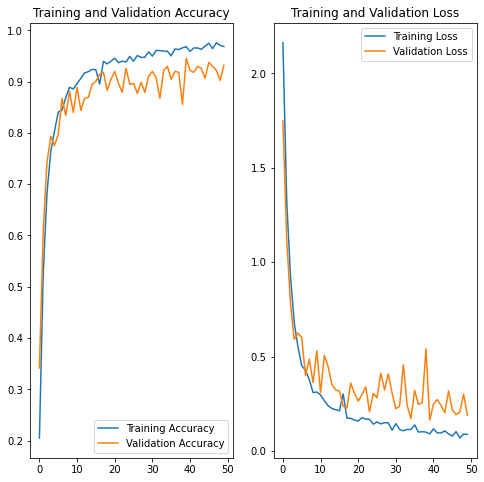

In [57]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

actual_label: Tomato___Tomato_Yellow_Leaf_Curl_Virus
1/1 [==============================] - 1s 867ms/step
predicted label: Tomato___Tomato_Yellow_Leaf_Curl_Virus


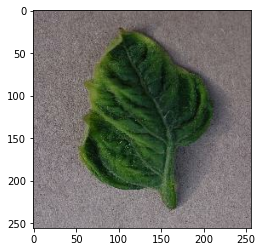

In [60]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    plt.imshow(first_image)
    print("actual_label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [61]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 62ms/step


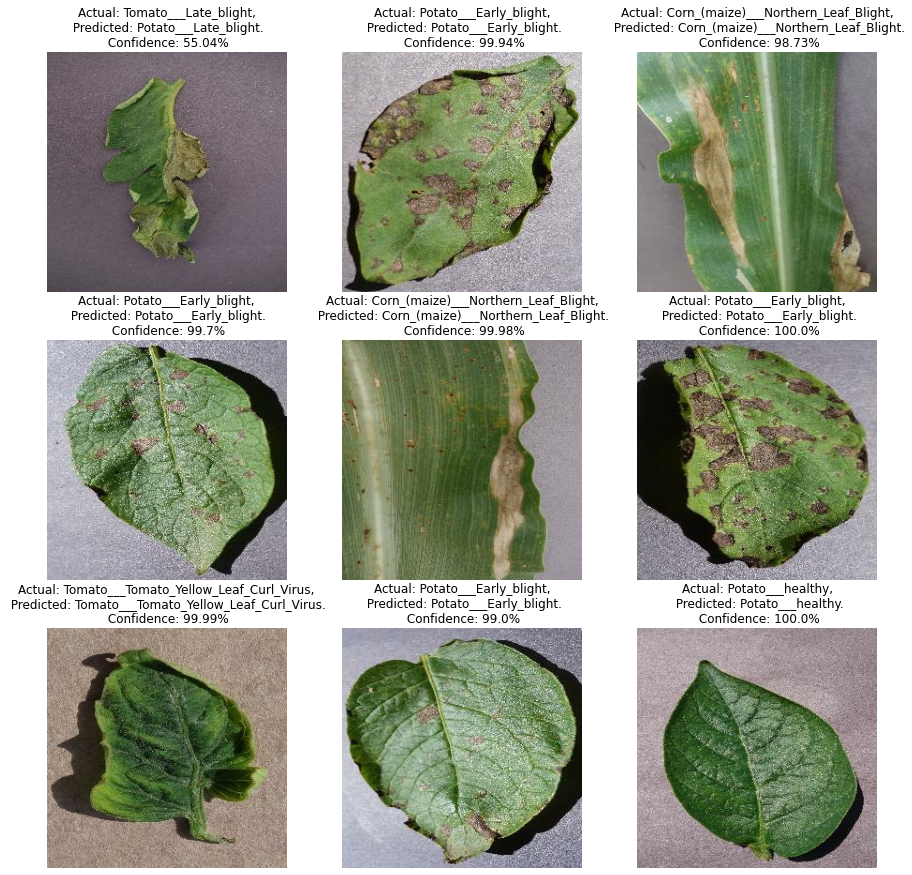

In [75]:
plt.figure(figsize=(15,15))
for images , labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class,confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [64]:
import os
model_version = max([int(i) for i in os.listdir("../models") + [0]]) +1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/3\assets


INFO:tensorflow:Assets written to: ../models/3\assets


In [53]:
print(2)

2
